## Autoencoder

In [1]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

1. train with batch
2. train-test split
3. validate our model with AUC

## Load Dataset

In [2]:
ppi = pd.read_csv('context-PPI_final.csv').head(1000)

In [3]:
mat_df = pd.crosstab(ppi['gene_a'], ppi['gene_b'])
idx = mat_df.columns.union(mat_df.index)
mat_df = mat_df.reindex(index = idx, columns=idx, fill_value=0)
mat = mat_df.values


## Get Training and Test Sets

In [4]:
permut = np.random.permutation(mat.shape[0])
train_num = int(mat.shape[0]*0.8)
train_idx = permut[:train_num]
test_idx = permut[train_num:]
print('train_num={}, test_num={}'.format(len(train_idx), len(test_idx)))

train_num=835, test_num=209


In [5]:
mat = torch.tensor(mat).float()
mat_train = mat[train_idx]
mat_test = mat[test_idx]
# mat_train =  torch.tensor(mat_train).float()
# mat_test = torch.tensor(mat_test).float()
print("train mat shape", mat_train.size(), "test mat shape",  mat_test.size())

train mat shape torch.Size([835, 1044]) test mat shape torch.Size([209, 1044])


## Model

In [6]:
class AutoEnc(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Linear(in_dim, in_dim//4),
            nn.ReLU(),
            nn.Linear(in_dim//4, in_dim//8),
            nn.ReLU(),
            nn.Linear(in_dim//8, in_dim//16),
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(in_dim//16, in_dim//8),
            nn.ReLU(),
            nn.Linear(in_dim//8, in_dim//4),
            nn.ReLU(),
            nn.Linear(in_dim//4, in_dim),
            nn.Sigmoid()
        )

    def forward(self, features):
        encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        return decoded

## Torch Dataset and DataLoader

In [7]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import auc, roc_curve


In [8]:
class LinkPredDataset(Dataset):
    def __init__(self, mat):
        self.mat = mat
        
    def __len__(self):
        return self.mat.size(0)
    
    def __getitem__(self, index):
        return self.mat[index]

In [9]:
# 하이퍼파라미터 준비
EPOCH = 2
BATCH_SIZE = 64


In [10]:
train_ds = LinkPredDataset(mat_train)
train_dl = DataLoader(train_ds, 
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=1,
                      drop_last=True)

test_ds = LinkPredDataset(mat_test)
test_dl = DataLoader(test_ds,batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=1,
                      drop_last=True)

## Train Model

In [11]:
model = AutoEnc(BATCH_SIZE * mat.size(1))
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e8)

outputs, losses = [], []

for epoch in range(EPOCH):
    model.train()
    print("------------- EPOCH {} -------------".format(epoch))
    for i, mat in enumerate(train_dl):
        input = mat.reshape(-1, mat.size(0) * mat.size(1))

        reconstructed = model(input)
        loss = loss_func(reconstructed, input)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        print("iter", i, "Loss", loss)

        losses.append(loss.detach())
        outputs.append((epoch, input, reconstructed))

        model.eval()
        with torch.no_grad():
            score = []
            for test_mat in test_dl:
                test_input = test_mat.reshape(-1, test_mat.size(0) * test_mat.size(1))
                test_reconstructed = model(test_input)
                
                true = test_input.reshape(-1).numpy()
                pred = test_reconstructed.reshape(-1).numpy()
                fpr, tpr, thresholds = roc_curve(true, pred, pos_label = 1)
                score.append(auc(fpr, tpr))
            print("AUC", np.mean(score))
        
                
                

------------- EPOCH 0 -------------
iter 0 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.505717720527252
iter 1 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.505411255238739
iter 2 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5051913514955036
iter 3 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5050260310889846
iter 4 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5049696805727547
iter 5 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5049280059103963
iter 6 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5048274395356832
iter 7 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.504806079533772
iter 8 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5047631605500654
iter 9 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5047382833664272
iter 10 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5047153023954858
iter 11 Loss tensor(0.2500, grad_fn=<MseLossBackward>)
AUC 0.5046668477497125
iter 12 Loss tensor(0.2500, grad_fn=<MseL

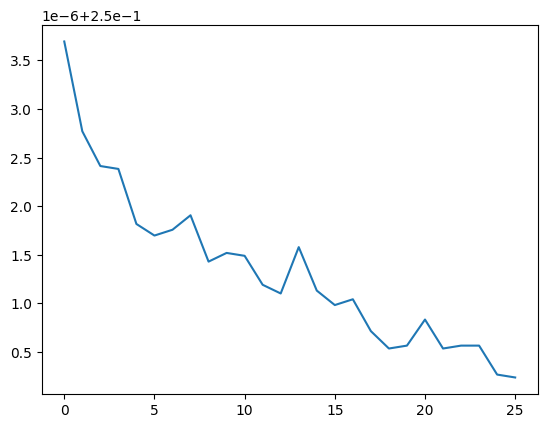

In [12]:
plt.plot(losses)